In [1]:
import sys
sys.path.append('..')

In [2]:
import planetengine
from planetengine import quickShow

In [3]:
import underworld as uw
from underworld import function as fn
import math
import numpy as np

from planetengine.utilities import Grouper

In [4]:
def build(
        res = 64,
        f = 0.9,
        aspect = 4.,
        periodic = False,
        refVisc = 1.,
        strength = 2.,
        slipperiness = 10.,
        astheno_thickness = 0.2,
        cont_buoy = 2.,
        Ra = 1e7,
        ):

    inputs = locals().copy()
    # script = __file__

    ### MESH & MESH VARIABLES ###

    f = max(0.00001, min(0.99999, f))
    inputs['f'] = f

    length = 1.
    outerRad = 1. / (1. - f)
    radii = (outerRad - length, outerRad)

    maxAspect = math.pi * sum(radii) / length
    aspect = min(aspect, maxAspect)
    inputs['aspect'] = aspect
    if aspect == maxAspect:
        periodic = True
        inputs['periodic'] = periodic

    width = length**2 * aspect * 2. / (radii[1]**2 - radii[0]**2)
    midpoint = math.pi / 2.
    angExtentRaw = (midpoint - 0.5 * width, midpoint + 0.5 * width)
    angExtentDeg = [item * 180. / math.pi for item in angExtentRaw]
    angularExtent = [
        max(0., angExtentDeg[0]),
        min(360., angExtentDeg[1] + abs(min(0., angExtentDeg[0])))
        ]
    angLen = angExtentRaw[1] - angExtentRaw[0]

    radRes = max(4, int(res / 4) * 4)
    inputs['res'] = radRes
    angRes = 4 * int(angLen * (int(radRes * radii[1] / length)) / 4)
    elementRes = (radRes, angRes)

    mesh = uw.mesh.FeMesh_Annulus(
        elementRes = elementRes,
        radialLengths = radii,
        angularExtent = angularExtent,
        periodic = [False, periodic]
        )

    ### VARIABLES ###

    pressureField = uw.mesh.MeshVariable(mesh.subMesh, 1)
    velocityField = uw.mesh.MeshVariable(mesh, 2)
    lithoField = uw.mesh.MeshVariable(mesh, 1)
    lithoDotField = uw.mesh.MeshVariable(mesh, 1)
    lithoVelField = uw.mesh.MeshVariable(mesh, 2)

    ### BOUNDARIES ###

    inner = mesh.specialSets["inner"]
    outer = mesh.specialSets["outer"]
    sides = mesh.specialSets["MaxJ_VertexSet"] + mesh.specialSets["MinJ_VertexSet"]

    if periodic:
        velBC = uw.conditions.RotatedDirichletCondition(
            variable = velocityField,
            indexSetsPerDof = (inner + outer, None),
            basis_vectors = (mesh.bnd_vec_normal, mesh.bnd_vec_tangent)
            )
    else:
        velBC = uw.conditions.RotatedDirichletCondition(
            variable = velocityField,
            indexSetsPerDof = (inner + outer, sides),
            basis_vectors = (mesh.bnd_vec_normal, mesh.bnd_vec_tangent)
            )

    lithoBC = uw.conditions.DirichletCondition(
        variable = lithoField,
        indexSetsPerDof = (inner + outer,)
        )

    ### SPECIAL ###

    # Needed for annulus to work properly
    vc = uw.mesh.MeshVariable(mesh = mesh, nodeDofCount = 2)
    vc_eqNum = uw.systems.sle.EqNumber(vc, False )
    vcVec = uw.systems.sle.SolutionVector(vc, vc_eqNum)

    ### FUNCTIONS ###

    depthFn = mesh.radialLengths[1] - mesh.radiusFn

    angExtentsRadians = np.array(mesh.angularExtent) * np.pi / 180.
    radWidth = angExtentsRadians[1] - angExtentsRadians[0]
    xFn, yFn = fn.input()[0], fn.input()[1]
    magnitudeFn = fn.math.sqrt(fn.math.pow(xFn, 2) + fn.math.pow(yFn, 2))
    rawAngFn = angFn = - 2. * fn.math.atan(yFn / ((magnitudeFn) + xFn))
    angFn = (rawAngFn + angExtentsRadians[1]) / radWidth

    angMag = fn.math.dot(mesh.unitvec_theta_Fn, vc)
    radMag = fn.math.dot(mesh.unitvec_r_Fn, vc)

    coolingFn = 1.

    lithoVelFn = angMag * mesh.unitvec_theta_Fn + (radMag - coolingFn) * mesh.unitvec_r_Fn

    depthCorrection = fn.branching.conditional([
        (depthFn < 0.8, lithoField),
        (True, lithoField * (depthFn - 0.8) / 0.2),
        ])
    limitCorrection = fn.branching.conditional([
        (lithoField < 0.01, 0.),
        (True, lithoField),
        ])

    def update_litho():
        lithoField.data[:] = np.clip(lithoField.data, 0., 1.)
        lithoField.data[:] = depthCorrection.evaluate(mesh)
        lithoField.data[:] = limitCorrection.evaluate(mesh)
        lithoField.data[:] = np.clip(lithoField.data, 0., 1.)
        lithoVelField.data[:] = lithoVelFn.evaluate(mesh)

    materialFn = fn.branching.conditional([
        (lithoField < 0.5 - astheno_thickness / 2., 0),
        (lithoField > 0.5 + astheno_thickness / 2., 2),
        (depthFn < 0.2, 1),
        (True, 0)
        ])

    mantleDensityFn = fn.math.log(depthFn + 1.) + 1.
    lithoDensityFn = cont_buoy * lithoField * mantleDensityFn
    asthenoDensityFn = (mantleDensityFn + lithoDensityFn) / 2.
    matDensityFn = fn.branching.map(
        fn_key = materialFn,
        mapping = {
            0: mantleDensityFn,
            1: asthenoDensityFn,
            2: lithoDensityFn,
            }
        )

    densityFn = Ra * matDensityFn

    ## RHEOLOGY ###

    mantleVisc = fn.math.log(2. - depthFn) + 1.
    matViscFn = fn.branching.map(
        fn_key = materialFn,
        mapping = {
            0: fn.math.log(2. - depthFn) + 1.,
            1: mantleVisc / slipperiness,
            2: strength * mantleVisc,
            }
        )

    viscosityFn = refVisc * matViscFn

    ### SYSTEMS ###

    stokes = uw.systems.Stokes(
        velocityField = velocityField,
        pressureField = pressureField,
        conditions = [velBC,],
        fn_viscosity = viscosityFn,
        fn_bodyforce = -densityFn * mesh.unitvec_r_Fn,
        _removeBCs = False,
        )

    solver = uw.systems.Solver(stokes)

    advDiff = uw.systems.AdvectionDiffusion(
        phiField = lithoField,
        phiDotField = lithoDotField,
        velocityField = lithoVelField,
        fn_diffusivity = 0.,
        fn_sourceTerm = 0.,
        conditions = [lithoBC,]
        )

    step = fn.misc.constant(0)
    modeltime = fn.misc.constant(0.)

    ### SOLVING ###

    def postSolve():
        # realign solution using the rotation matrix on stokes
        uw.libUnderworld.Underworld.AXequalsY(
            stokes._rot._cself,
            stokes._velocitySol._cself,
            vcVec._cself,
            False
            )
        # remove null space - the solid body rotation velocity contribution
        uw.libUnderworld.StgFEM.SolutionVector_RemoveVectorSpace(
            stokes._velocitySol._cself, 
            stokes._vnsVec._cself
            )
    #     update_litho()

    def solve():
        update_litho()
        velocityField.data[:] = 0.
        solver.solve(
            nonLinearIterate = False,
            callback_post_solve = postSolve,
            )
        uw.libUnderworld.Underworld.AXequalsX(
            stokes._rot._cself,
            stokes._velocitySol._cself,
            False
            )

    def integrate():
        dt = advDiff.get_max_dt()
        advDiff.integrate(dt)
        modeltime.value += dt
        step.value += 1

    def iterate():
        integrate()
        solve()

    ### HOUSEKEEPING: IMPORTANT! ###

    varsOfState = {'lithoField': lithoField}

    return Grouper(locals())

In [17]:
system = build(
    res = 16,
    Ra = 1e6,
    strength = 1e3,
    aspect = 12.,
    slipperiness = 4.,
    f = 0.54,
    astheno_thickness = 1. / 3.
    )

In [27]:
# quick and dirty initialise:
boxDims = ((0., 1.),) * system.mesh.dim
box = planetengine.mapping.box(system.mesh, system.mesh.data, boxDims)
system.lithoField.data[:] = (1. - planetengine.initials.sinusoidal.IC(freq = 8., pert = 0.3).evaluate(box))**5.

In [28]:
system.solve()

In [29]:
# onlyContVelocityFn = fn.branching.map(
#     fn_key = system.materialFn,
#     mapping = {
#         0: [0., 0.],
#         1: [0., 0.],
#         2: system.velocityField
#         }
#     )

In [30]:
show = lambda: quickShow(
#     system.lithoField,
    system.densityFn,
    system.velocityField,
#     onlyContVelocityFn,
    system.viscosityFn,
    system.materialFn,
    resolution = (2048, 1024)
    )

Fitted 4 variables to the figure.



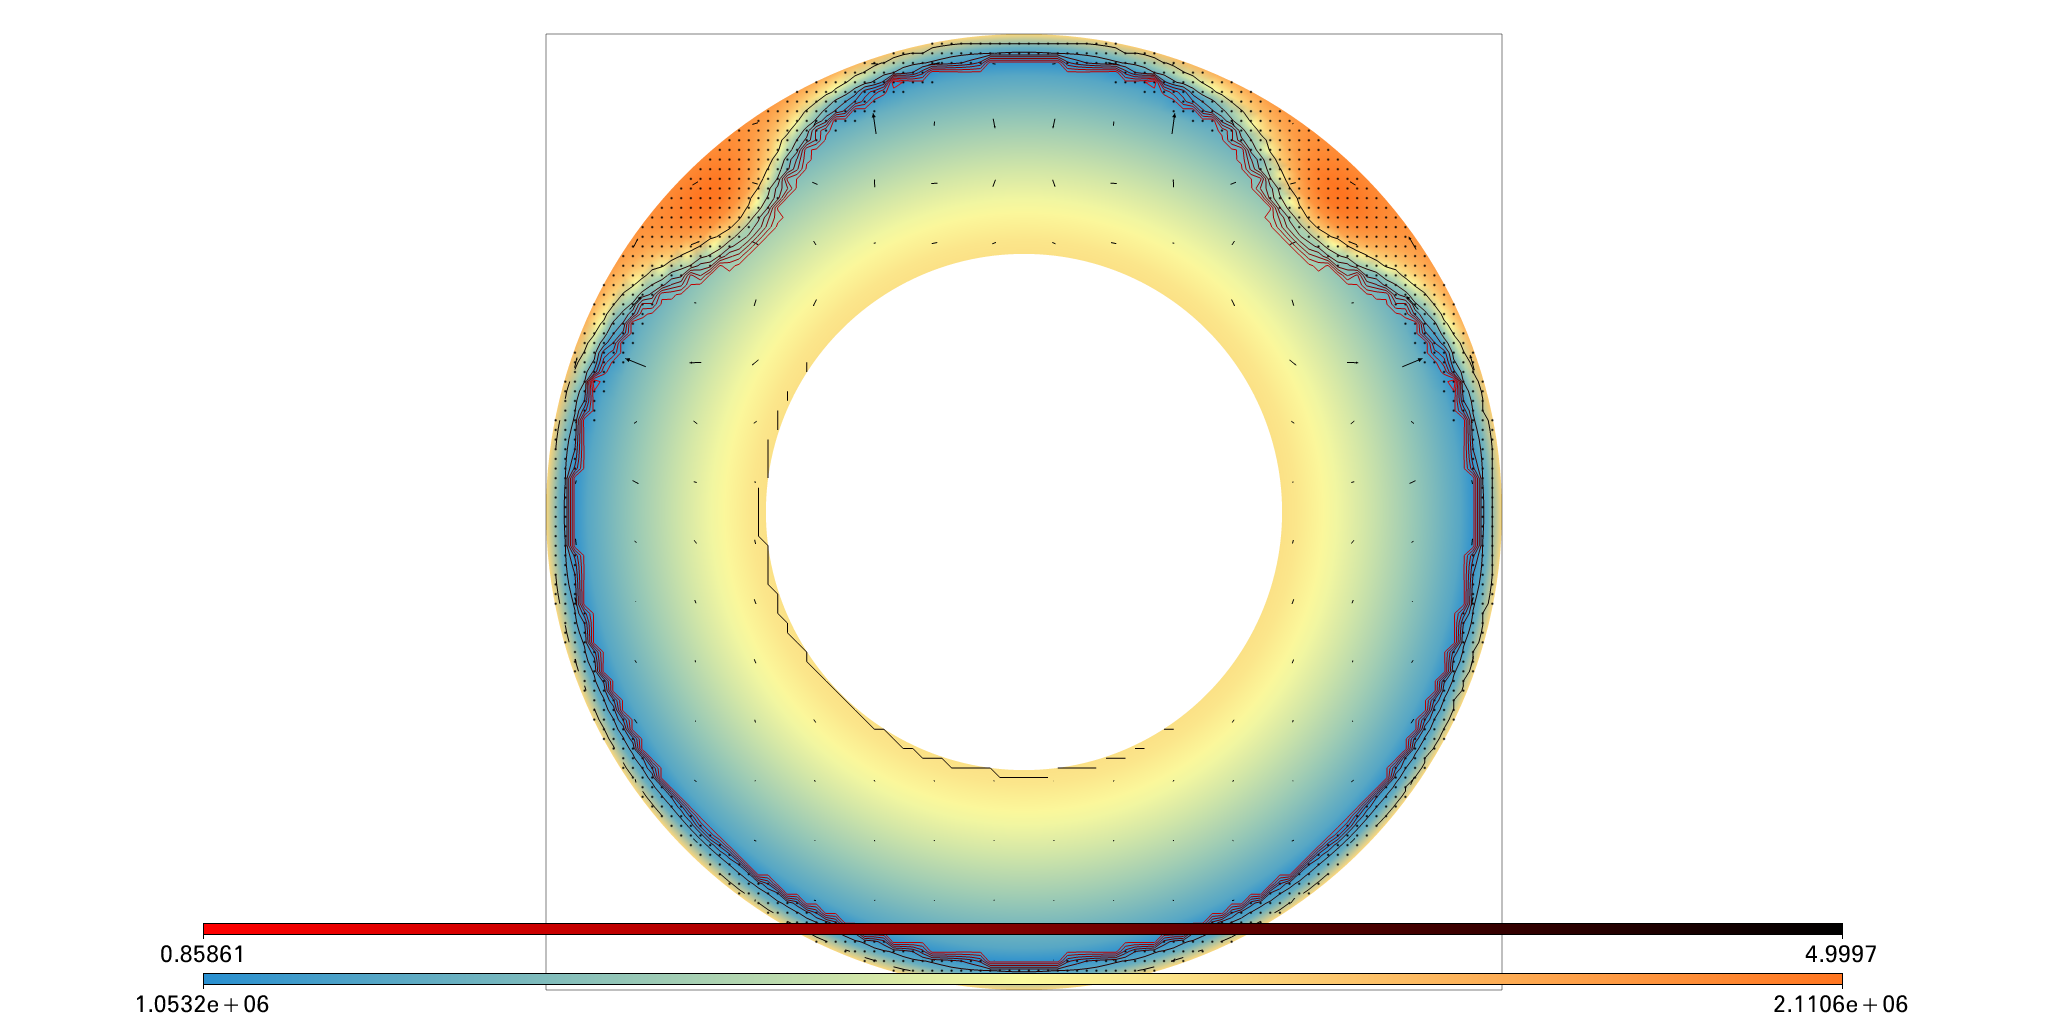

In [31]:
show()

Iteration 0
Fitted 4 variables to the figure.



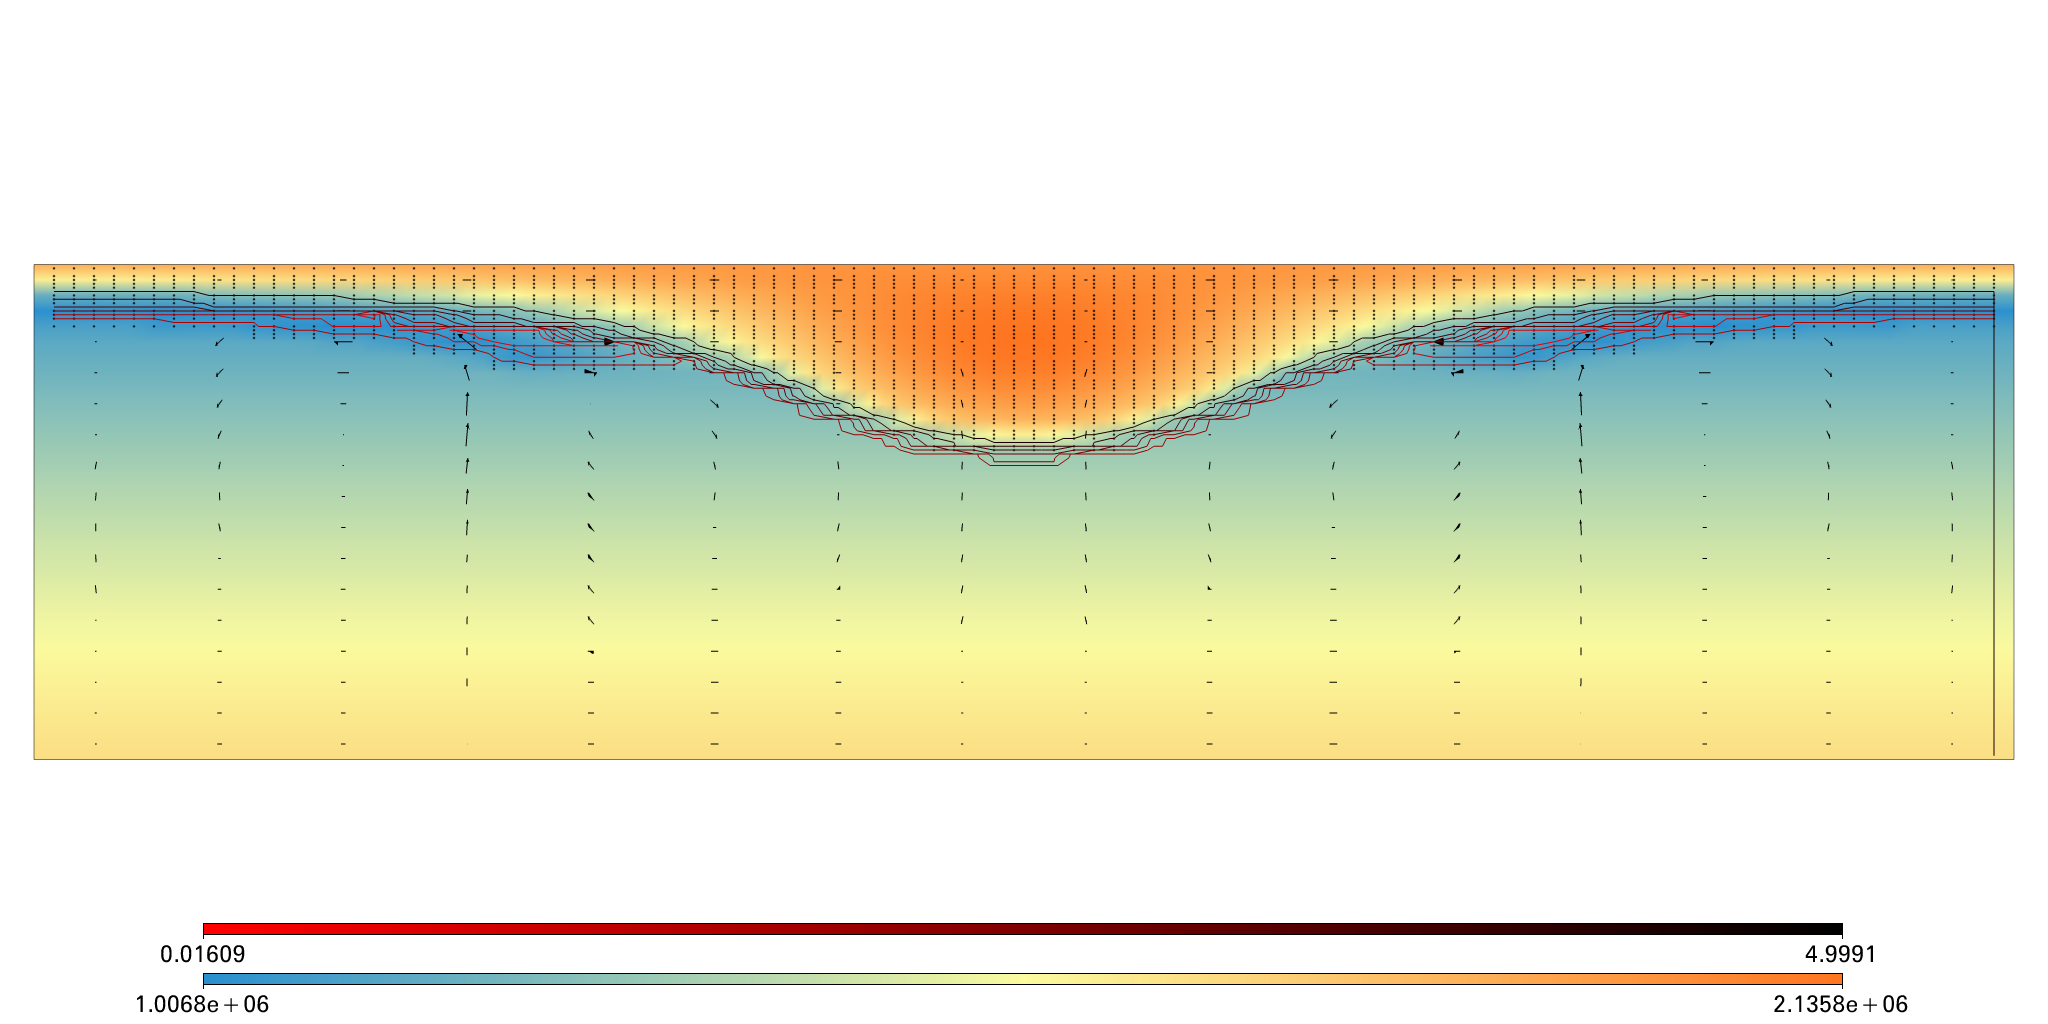

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Fitted 4 variables to the figure.



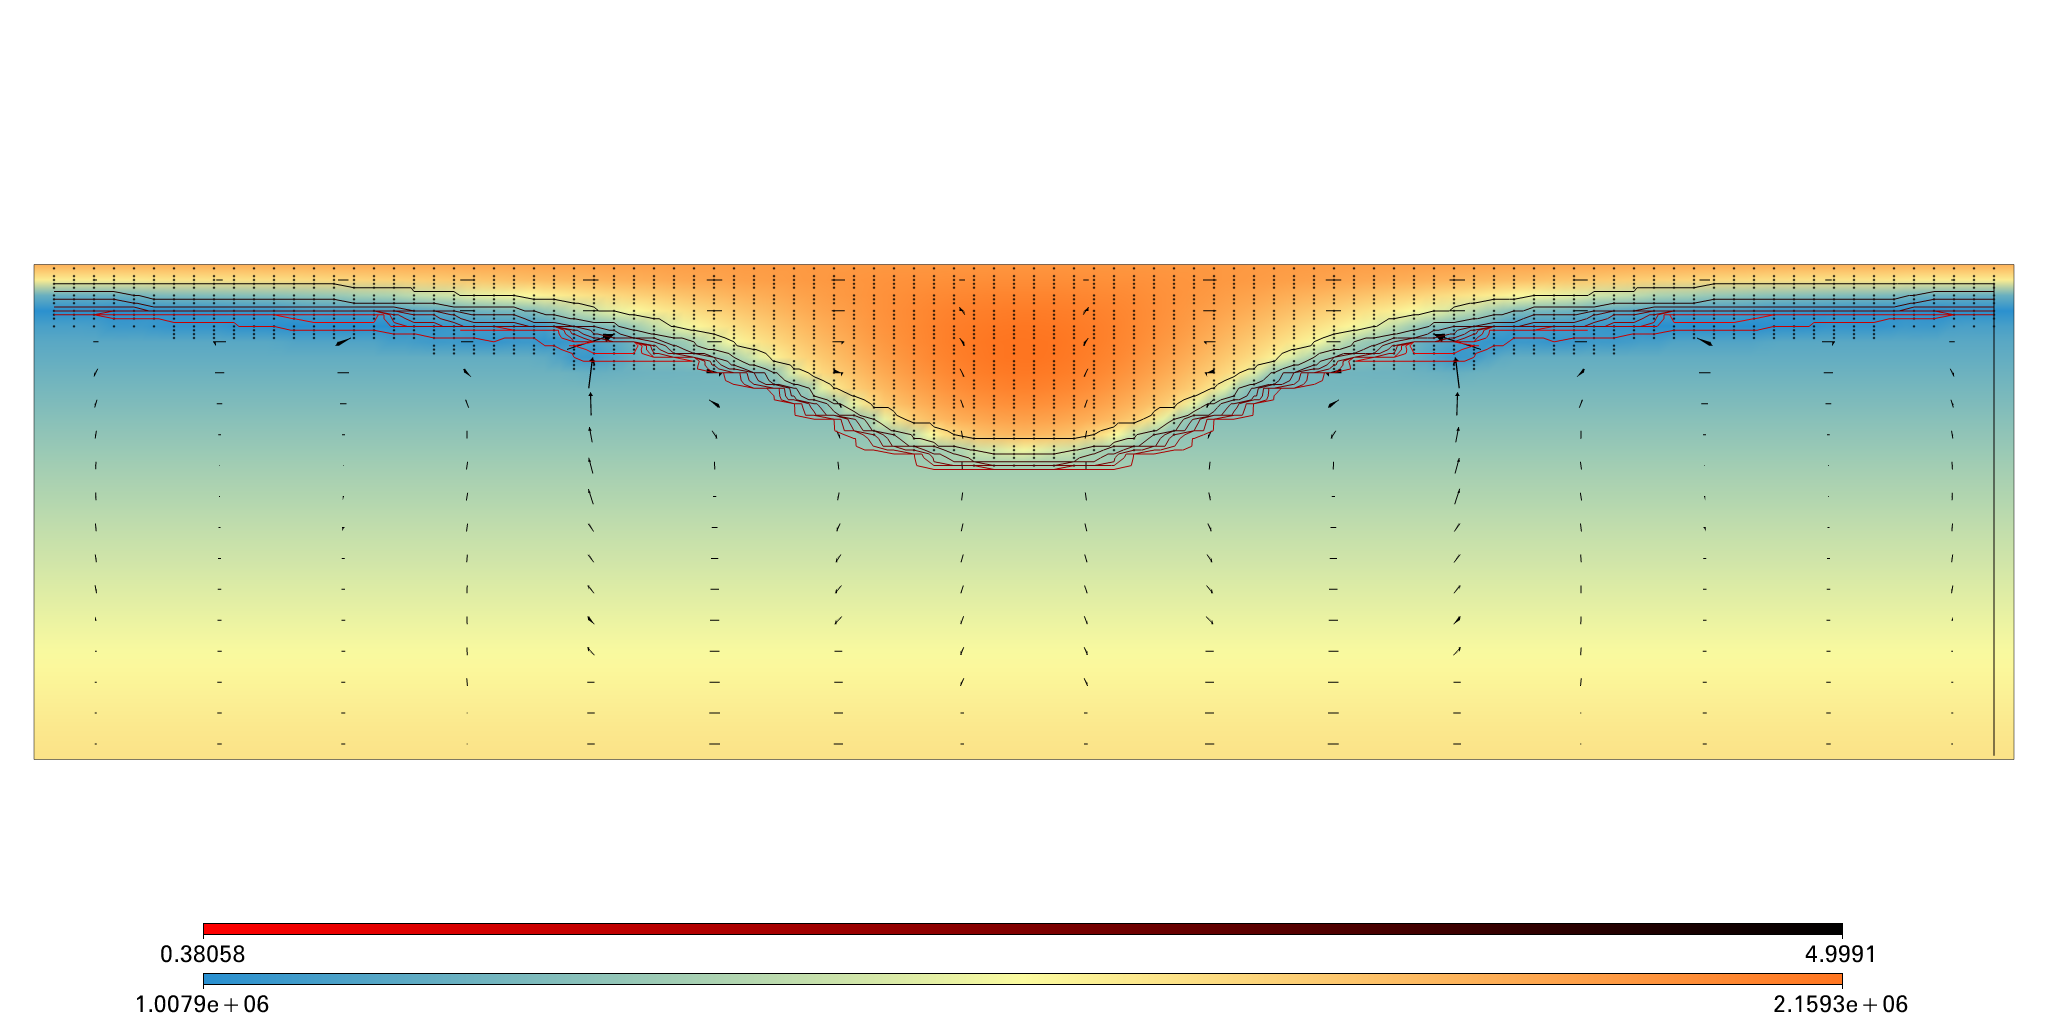

Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Fitted 4 variables to the figure.



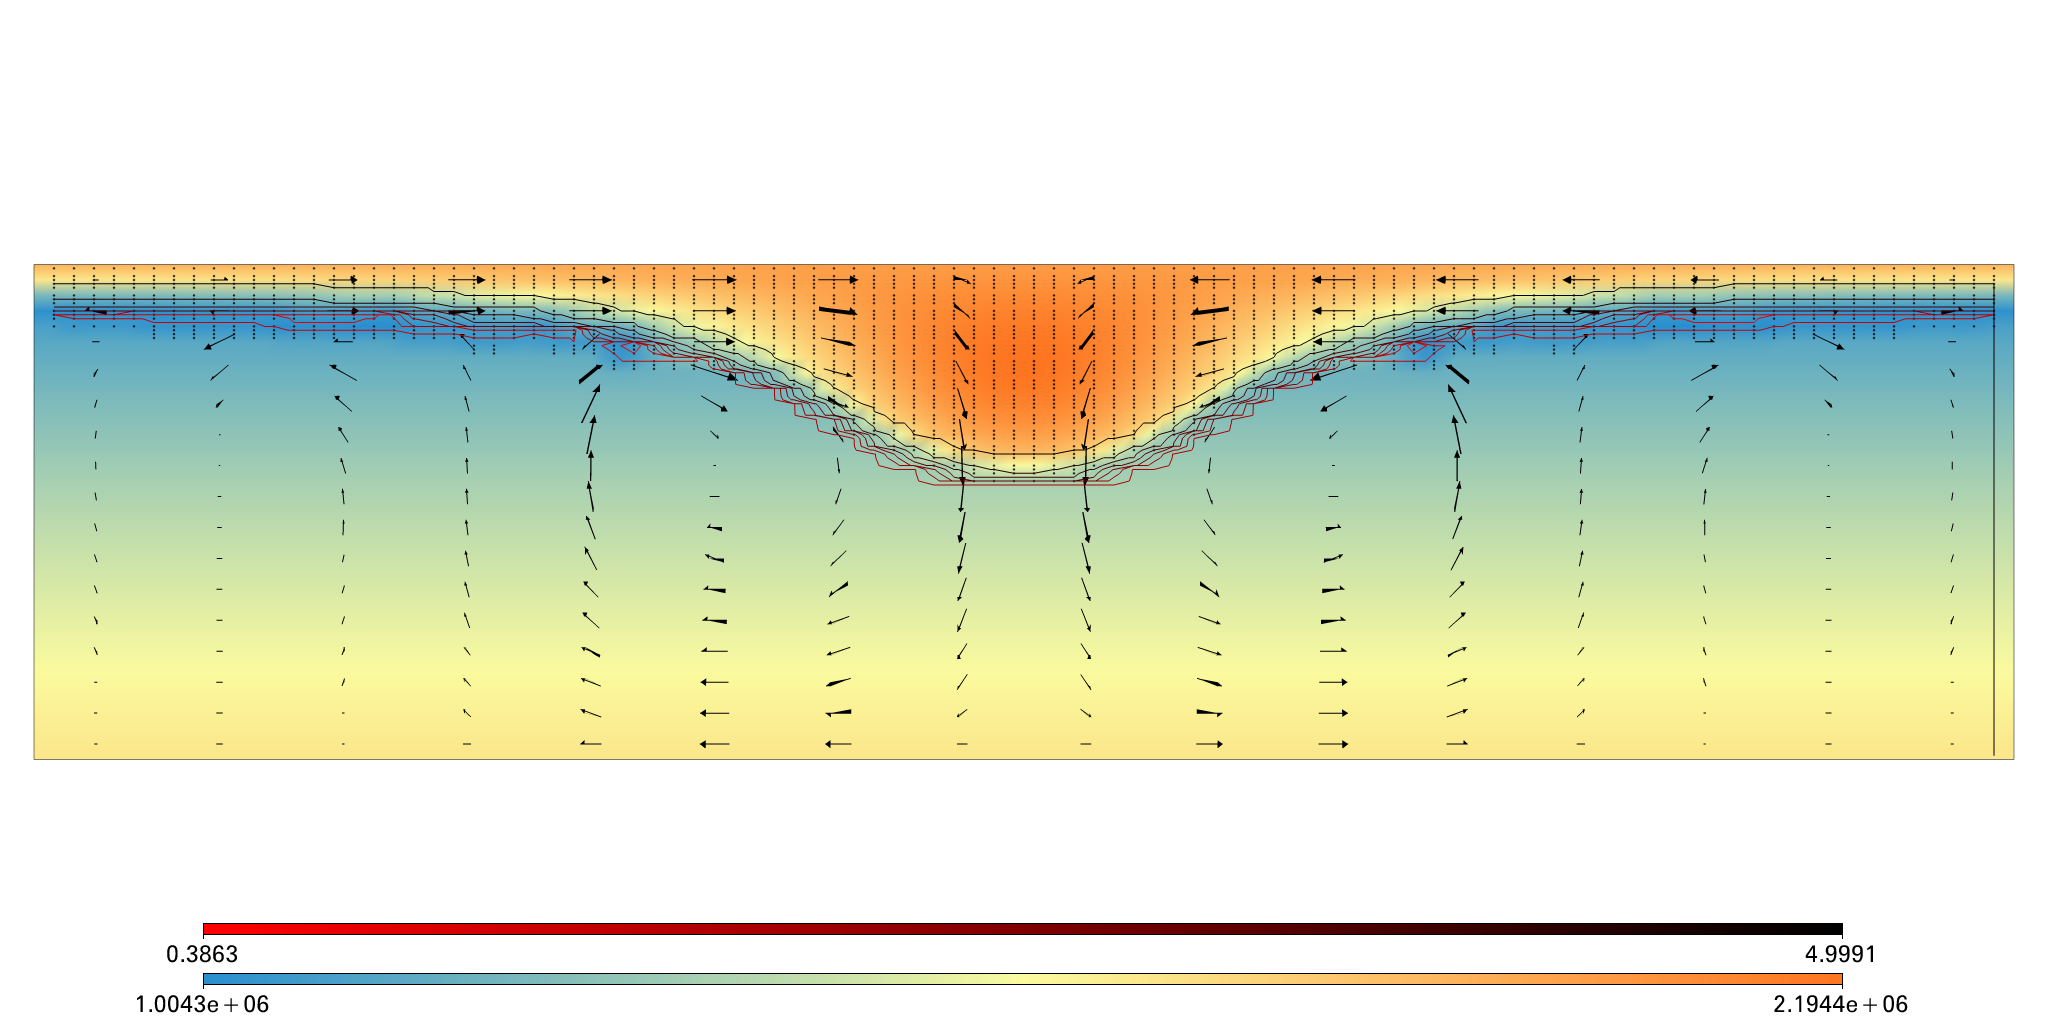

Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Fitted 4 variables to the figure.



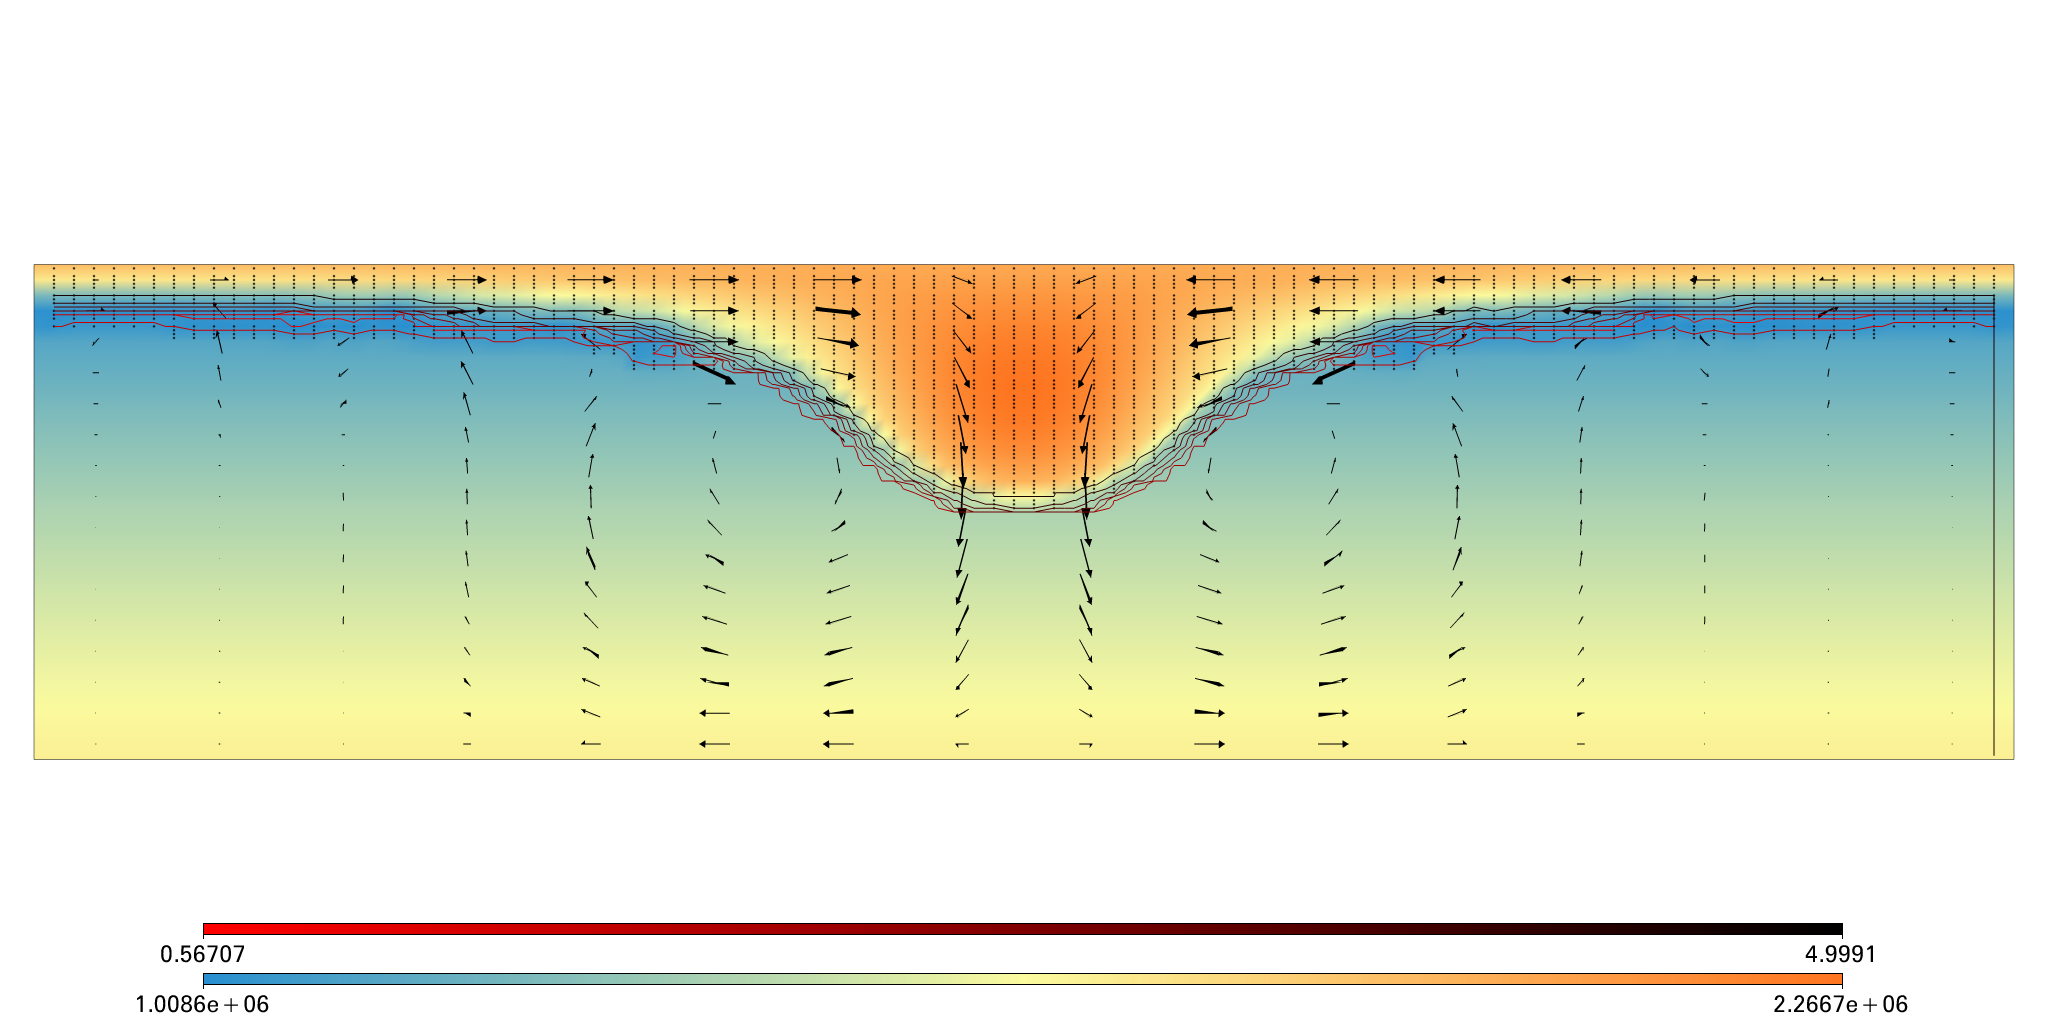

Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Fitted 4 variables to the figure.



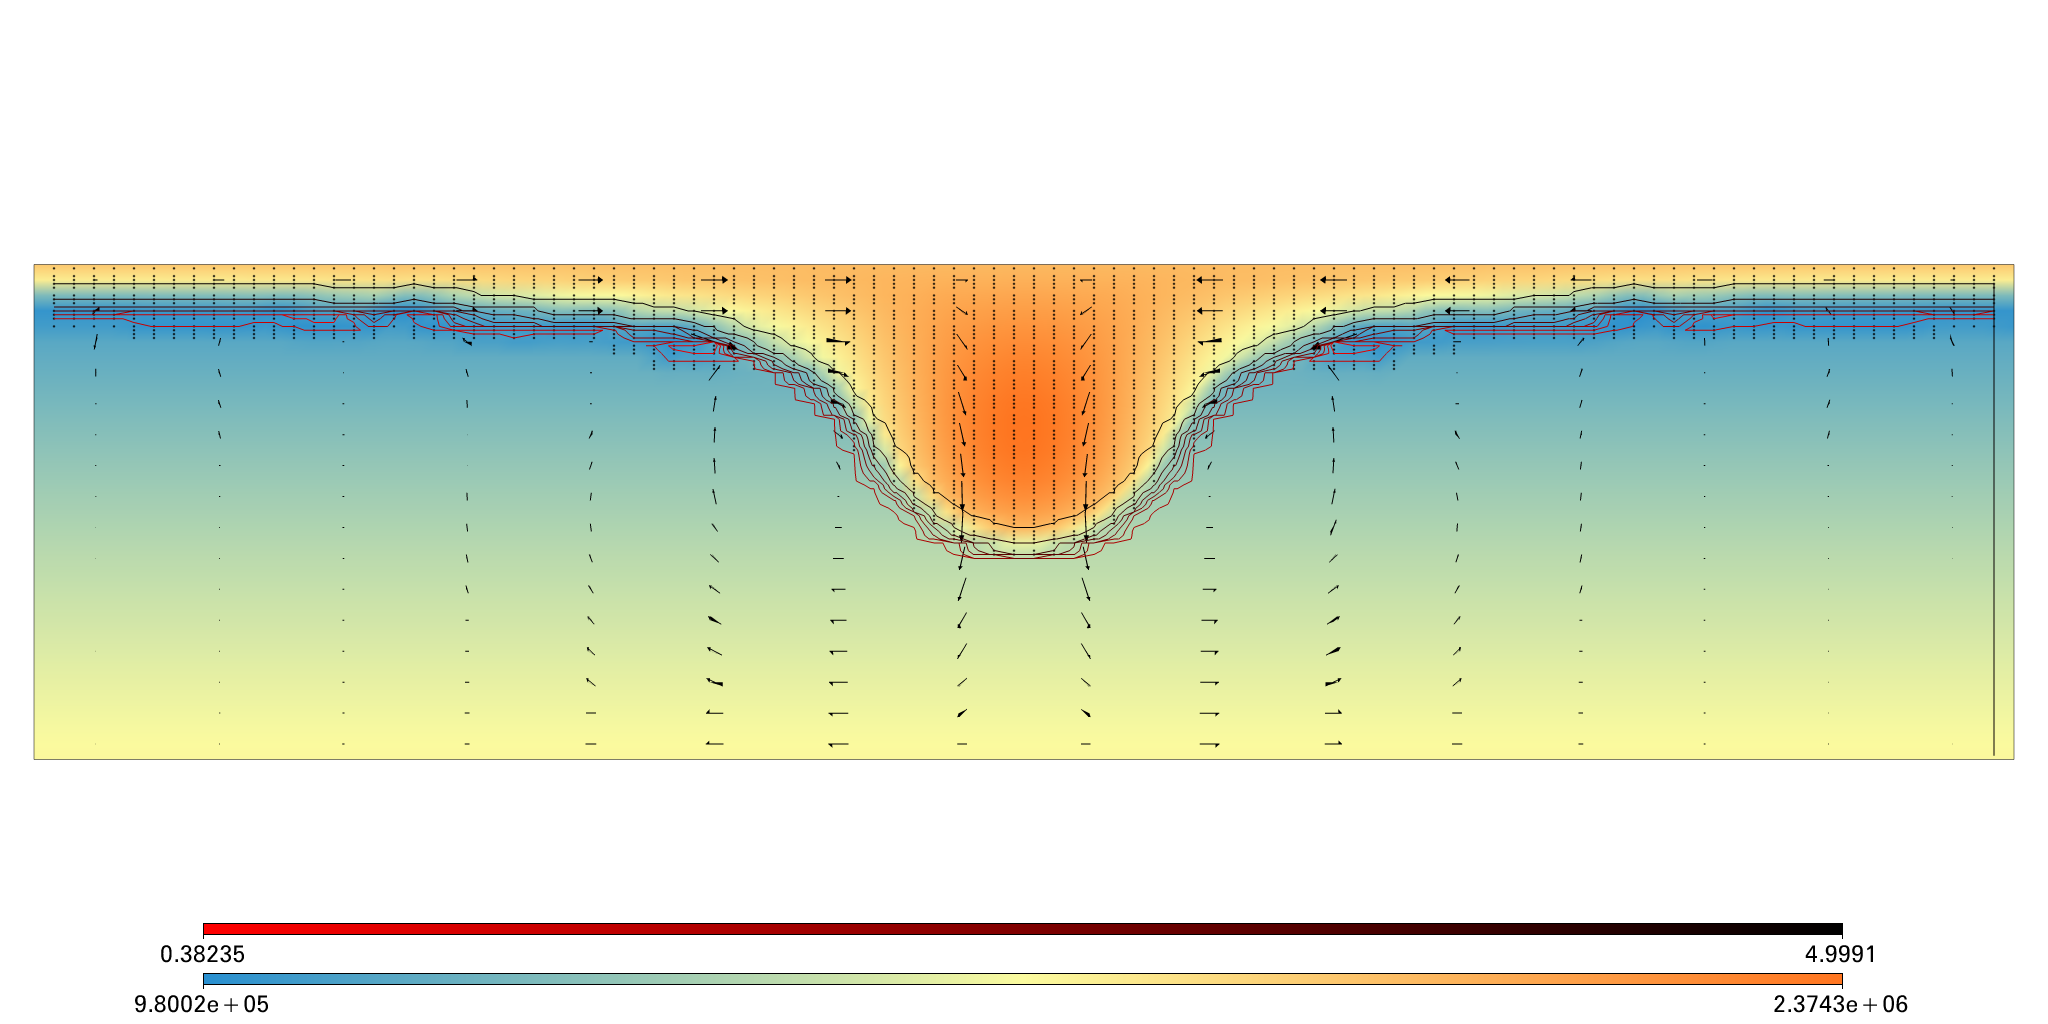

Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Fitted 4 variables to the figure.



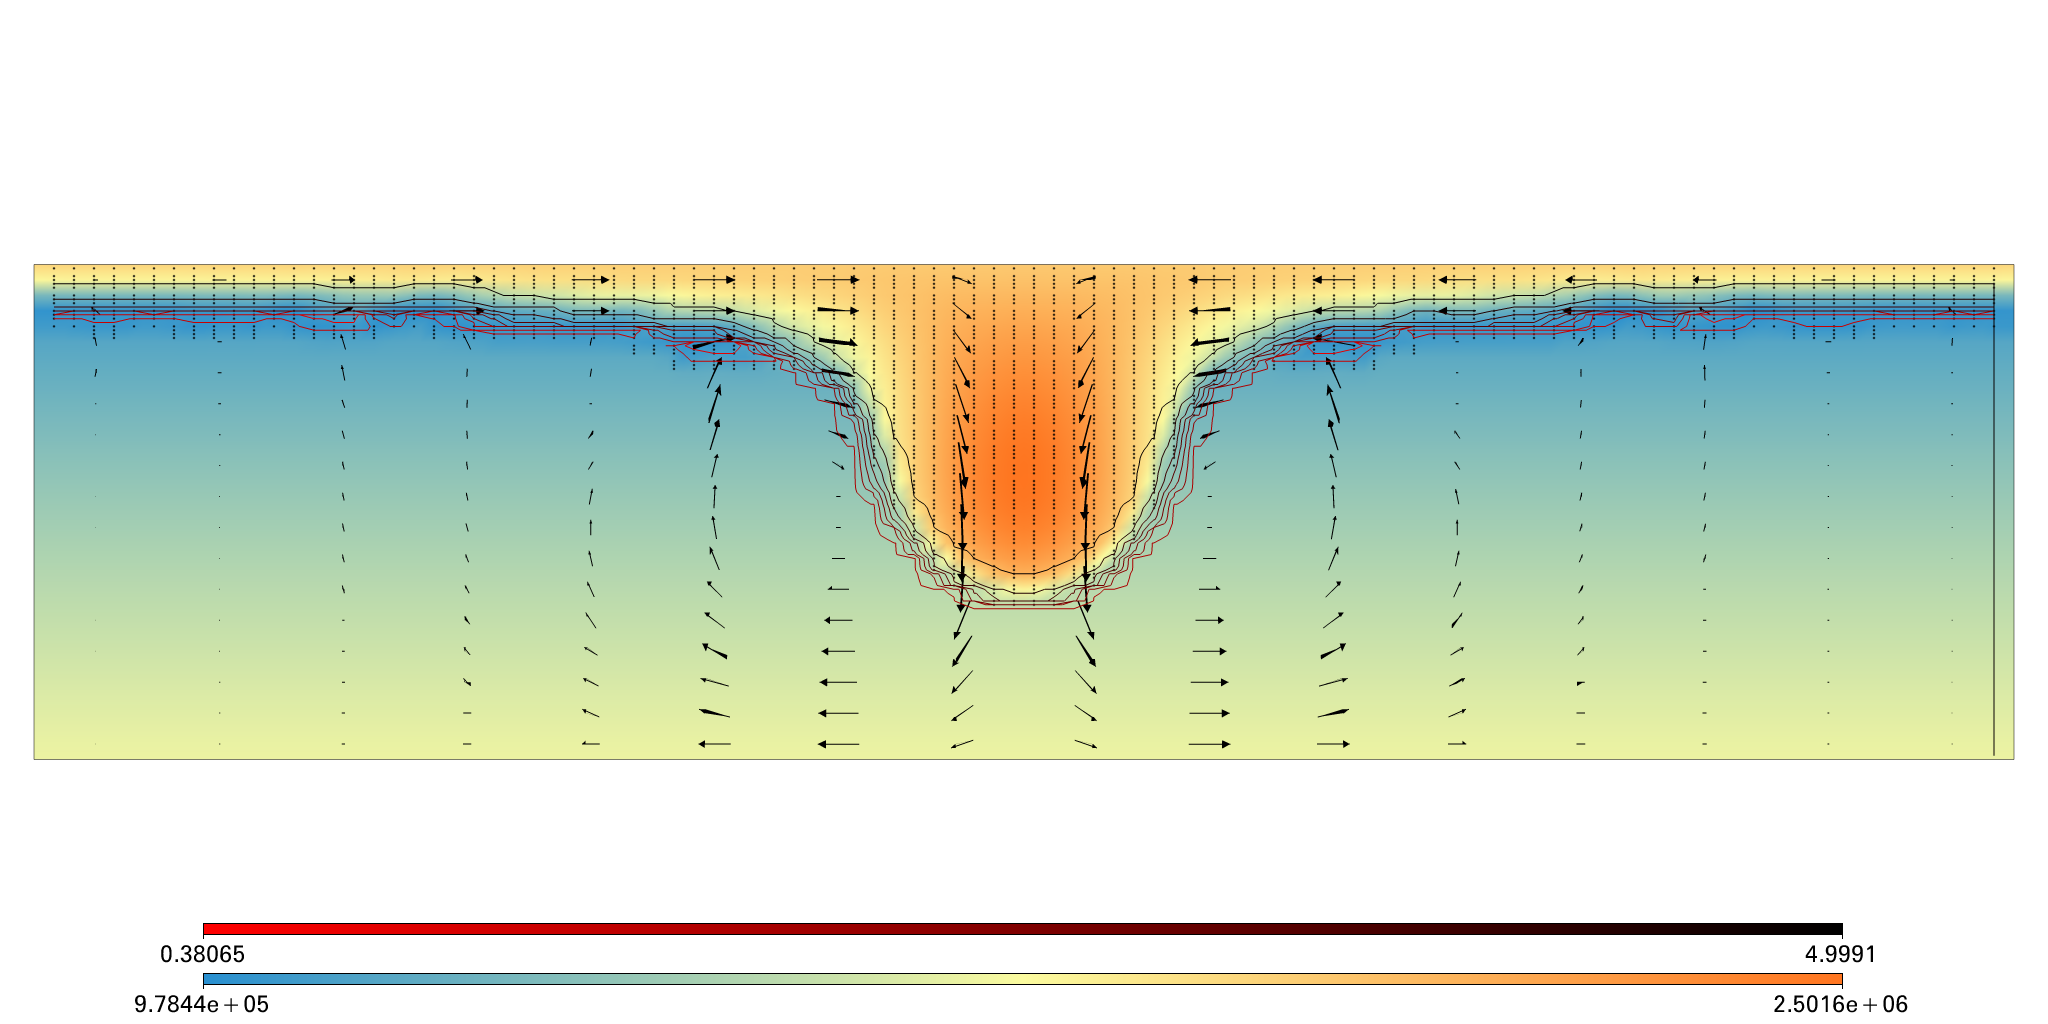

Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Fitted 4 variables to the figure.



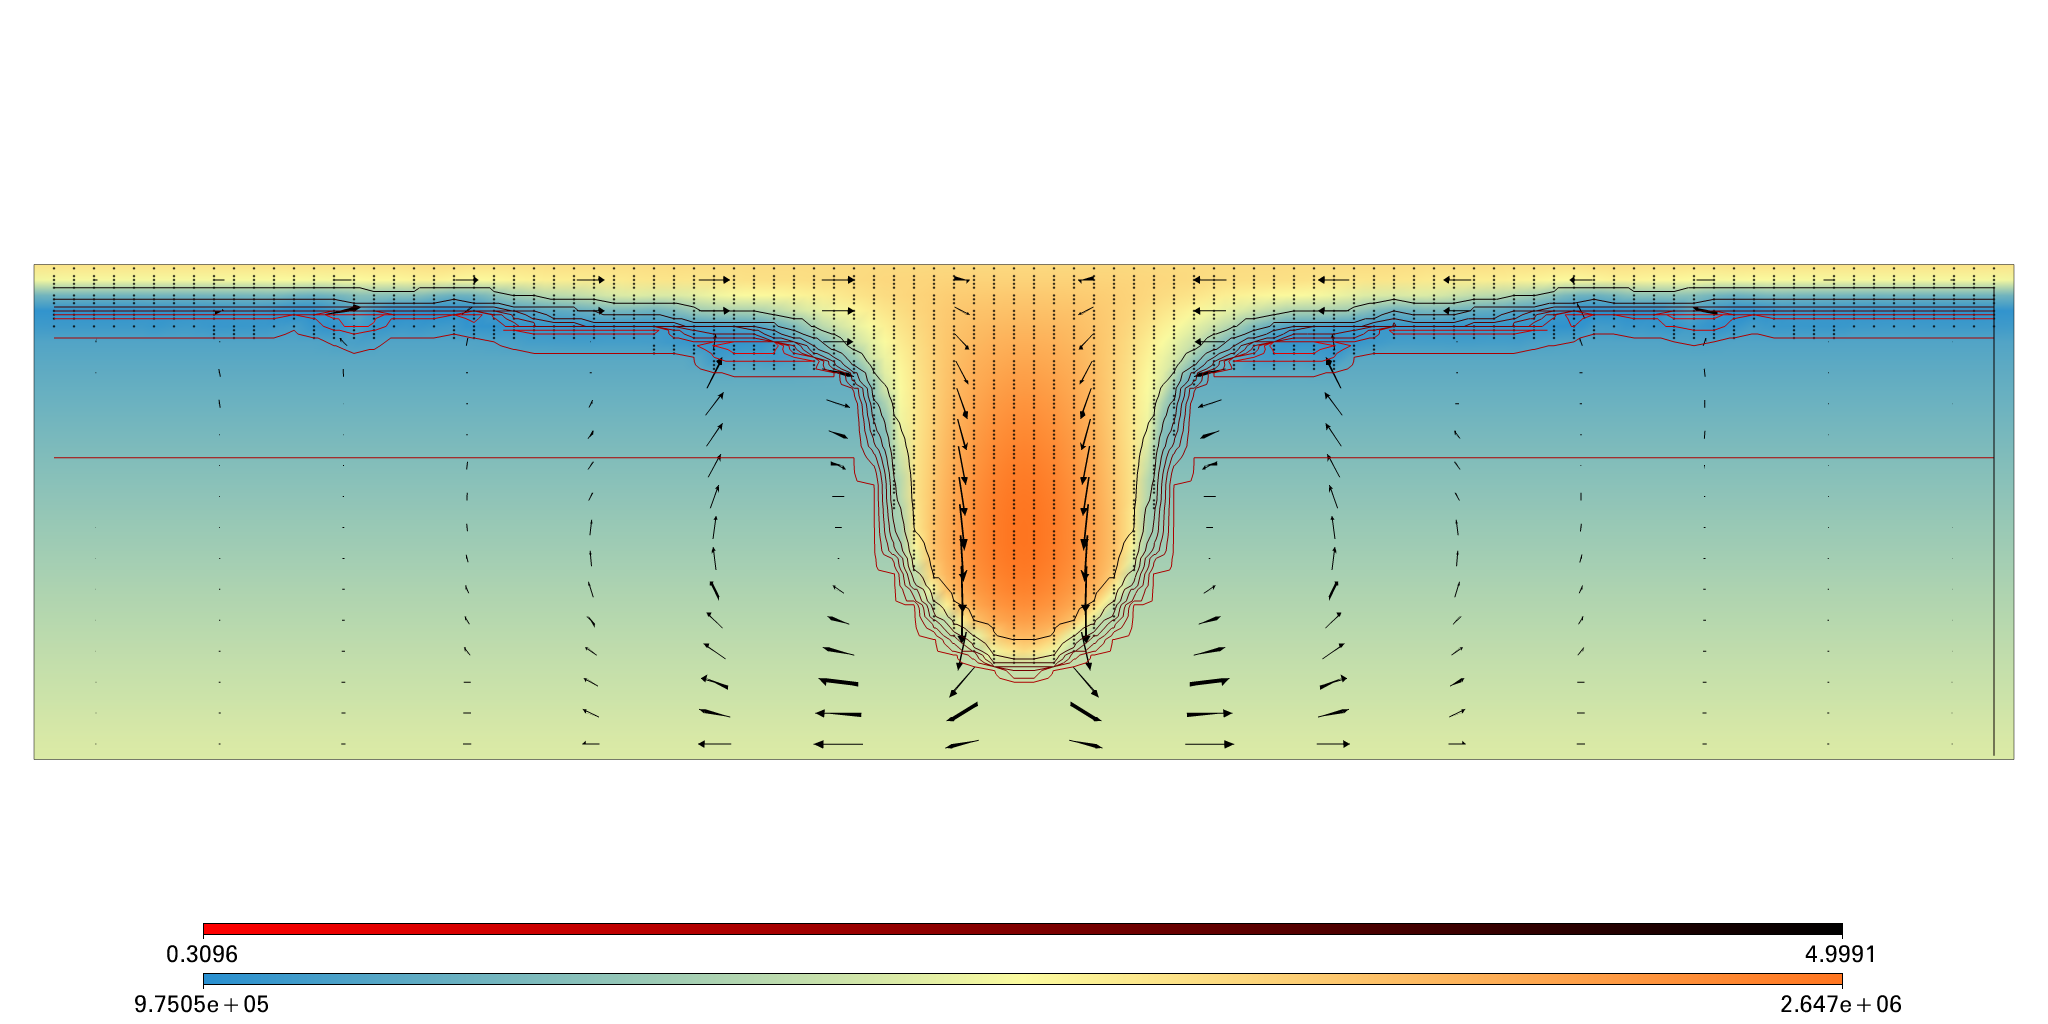

Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Fitted 4 variables to the figure.



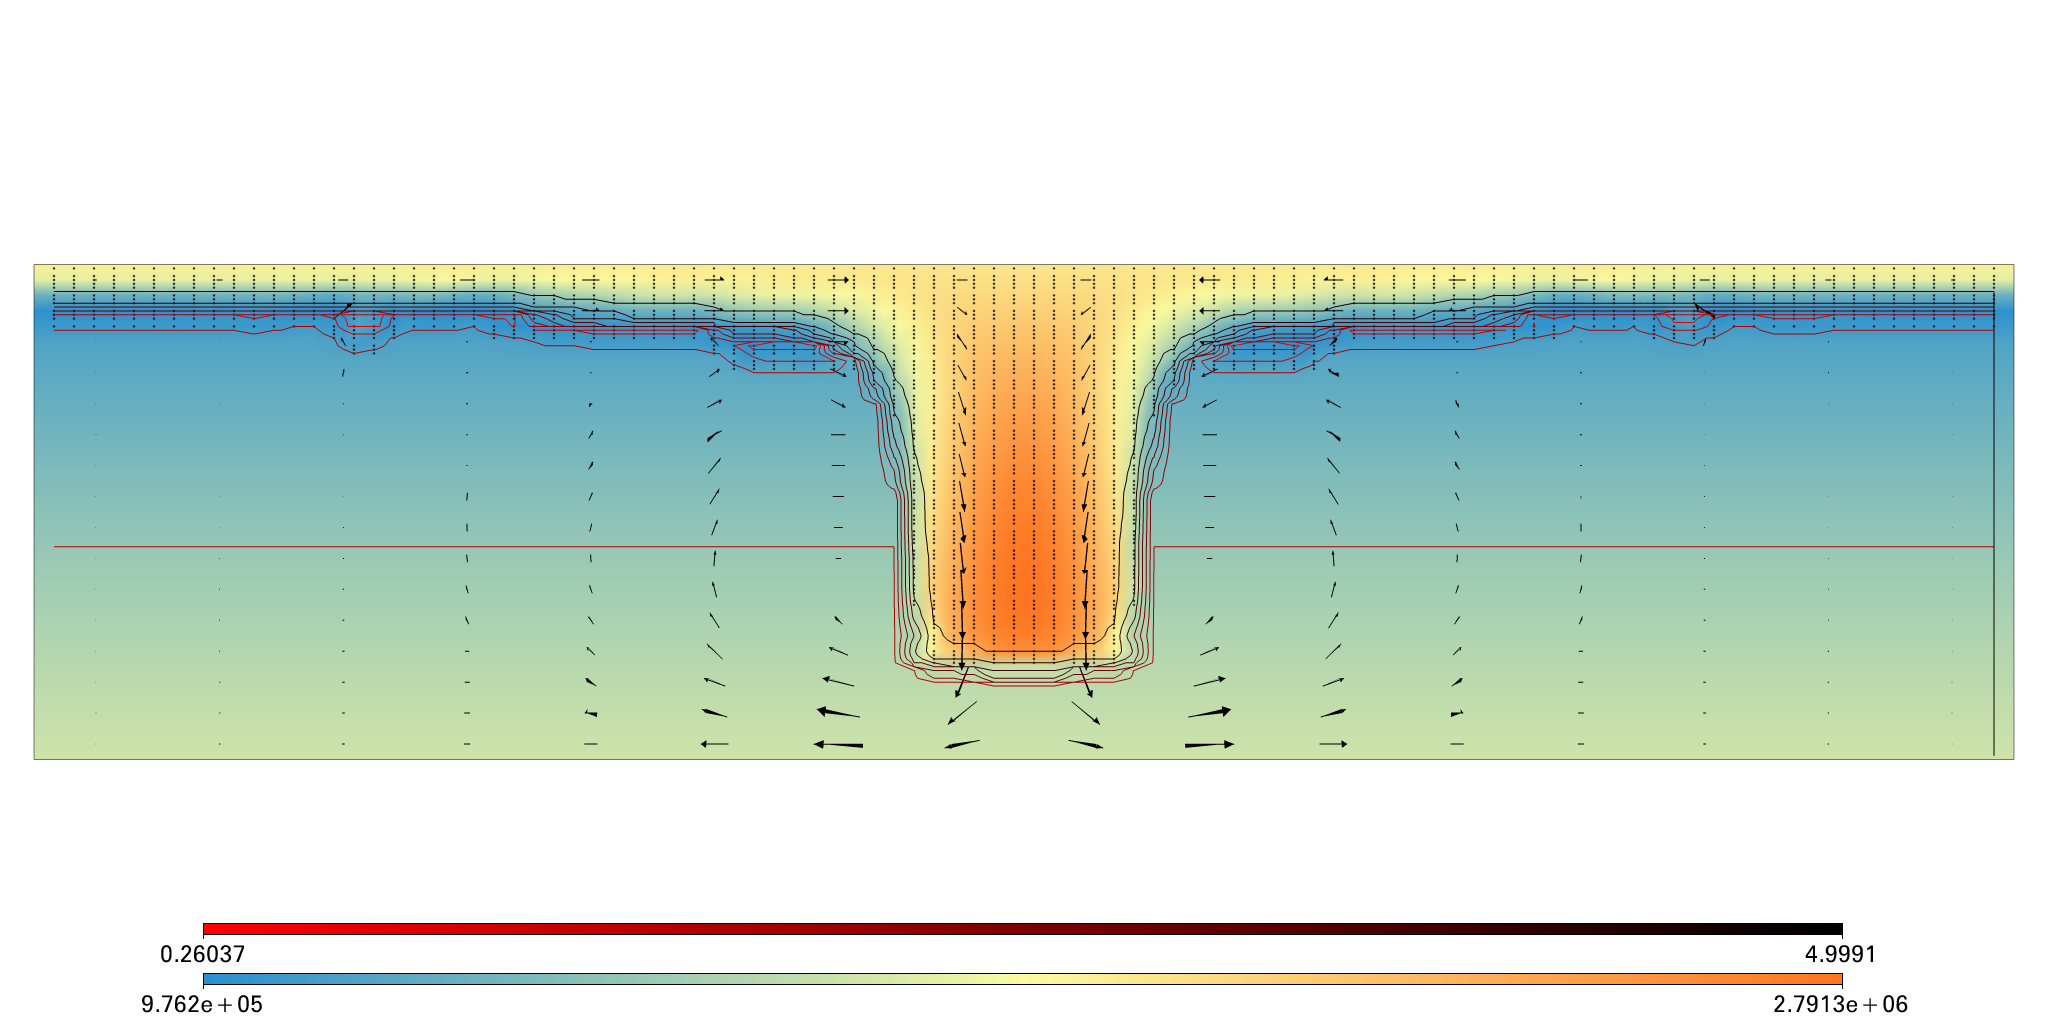

Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteration 78
Iteration 79
Iteration 80
Fitted 4 variables to the figure.



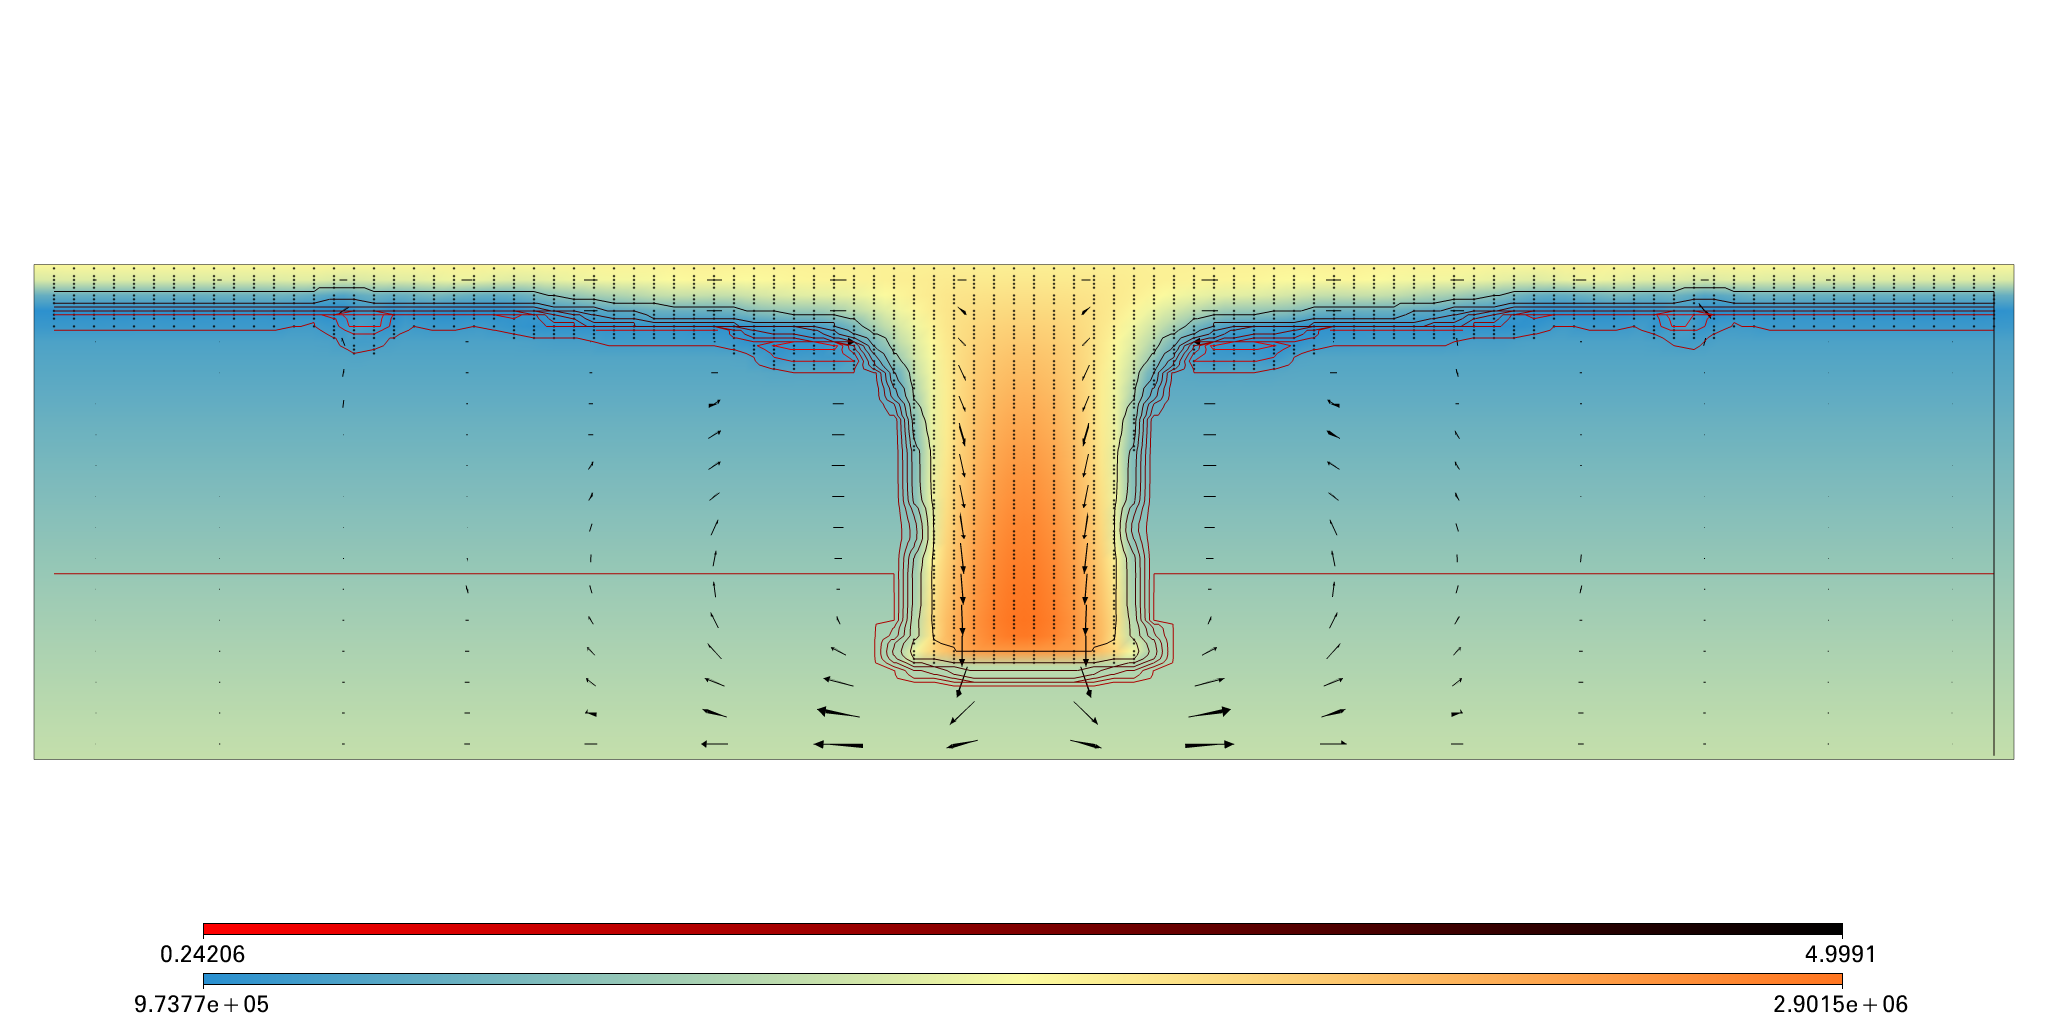

Iteration 81
Iteration 82
Iteration 83
Iteration 84
Iteration 85
Iteration 86
Iteration 87
Iteration 88
Iteration 89
Iteration 90
Fitted 4 variables to the figure.



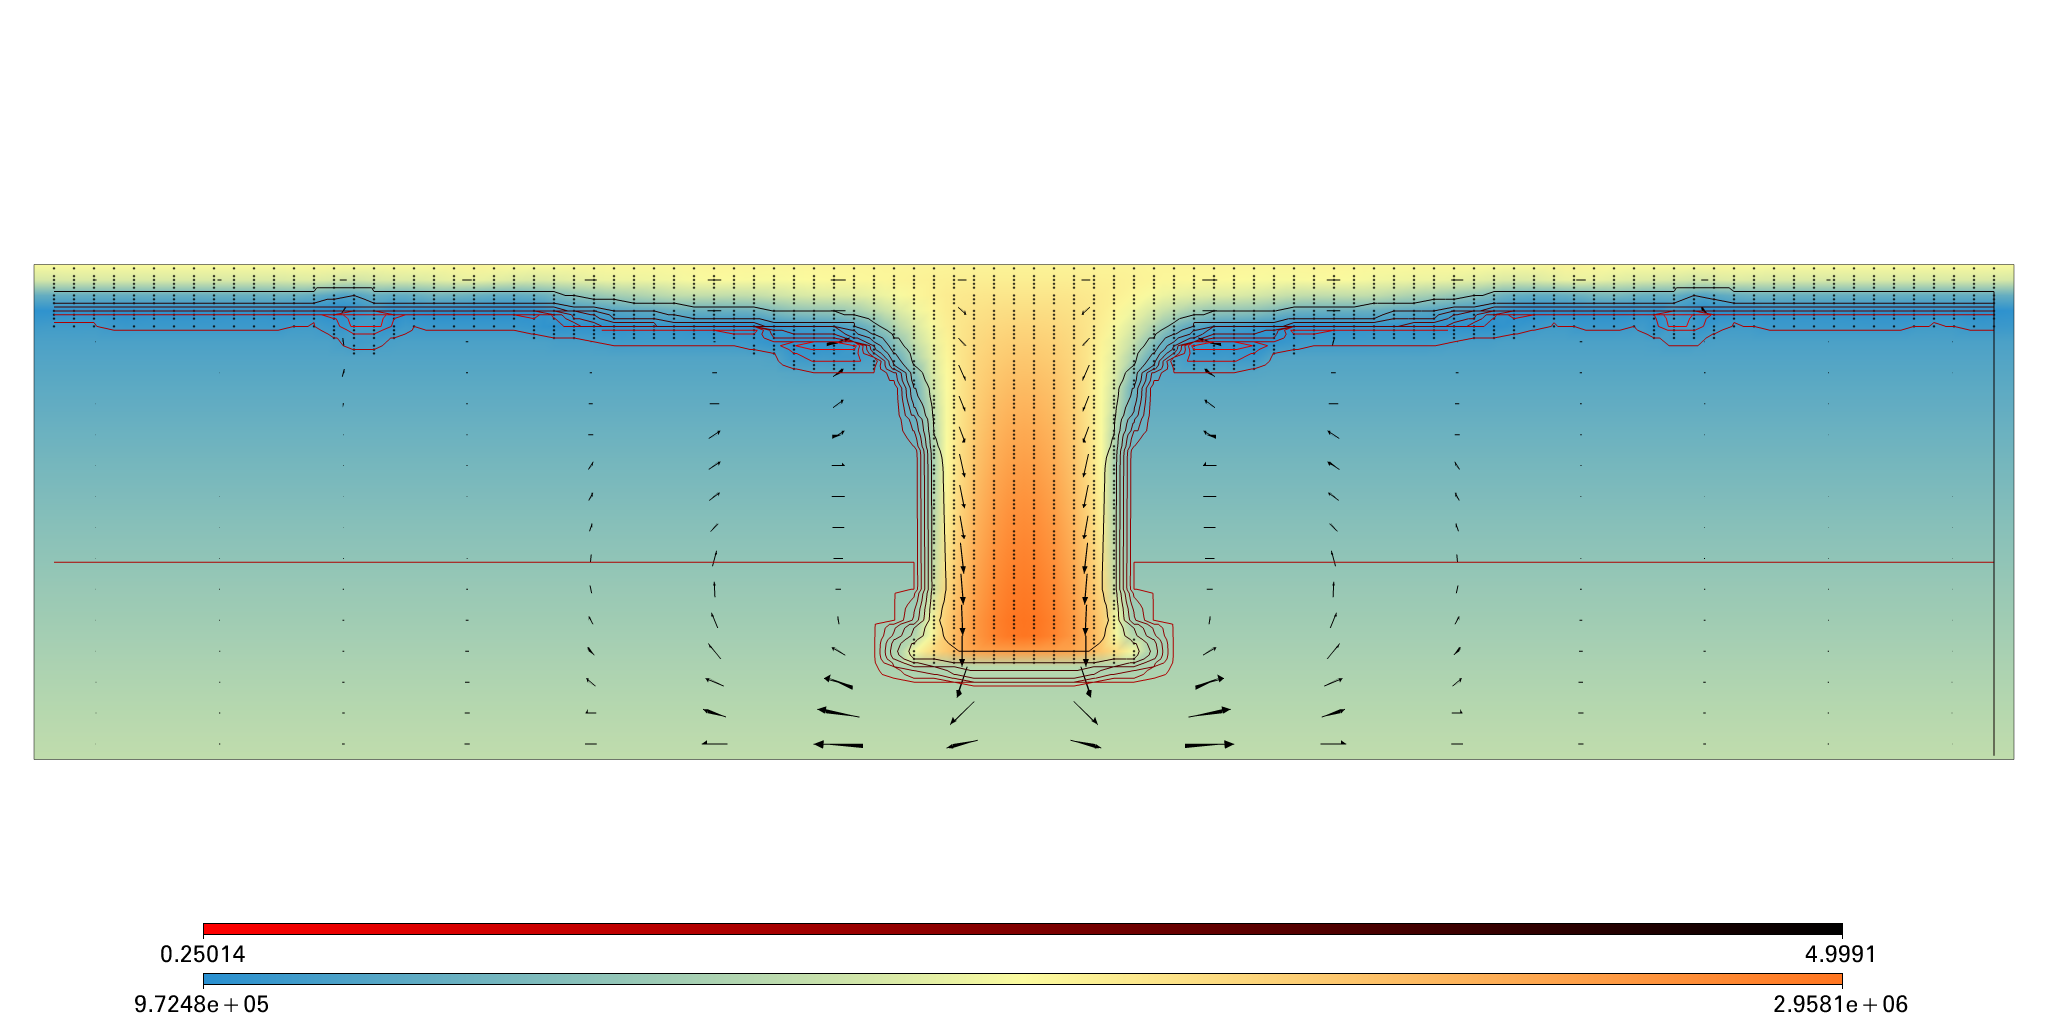

Iteration 91
Iteration 92
Iteration 93
Iteration 94
Iteration 95
Iteration 96
Iteration 97
Iteration 98
Iteration 99
Done!
Fitted 4 variables to the figure.



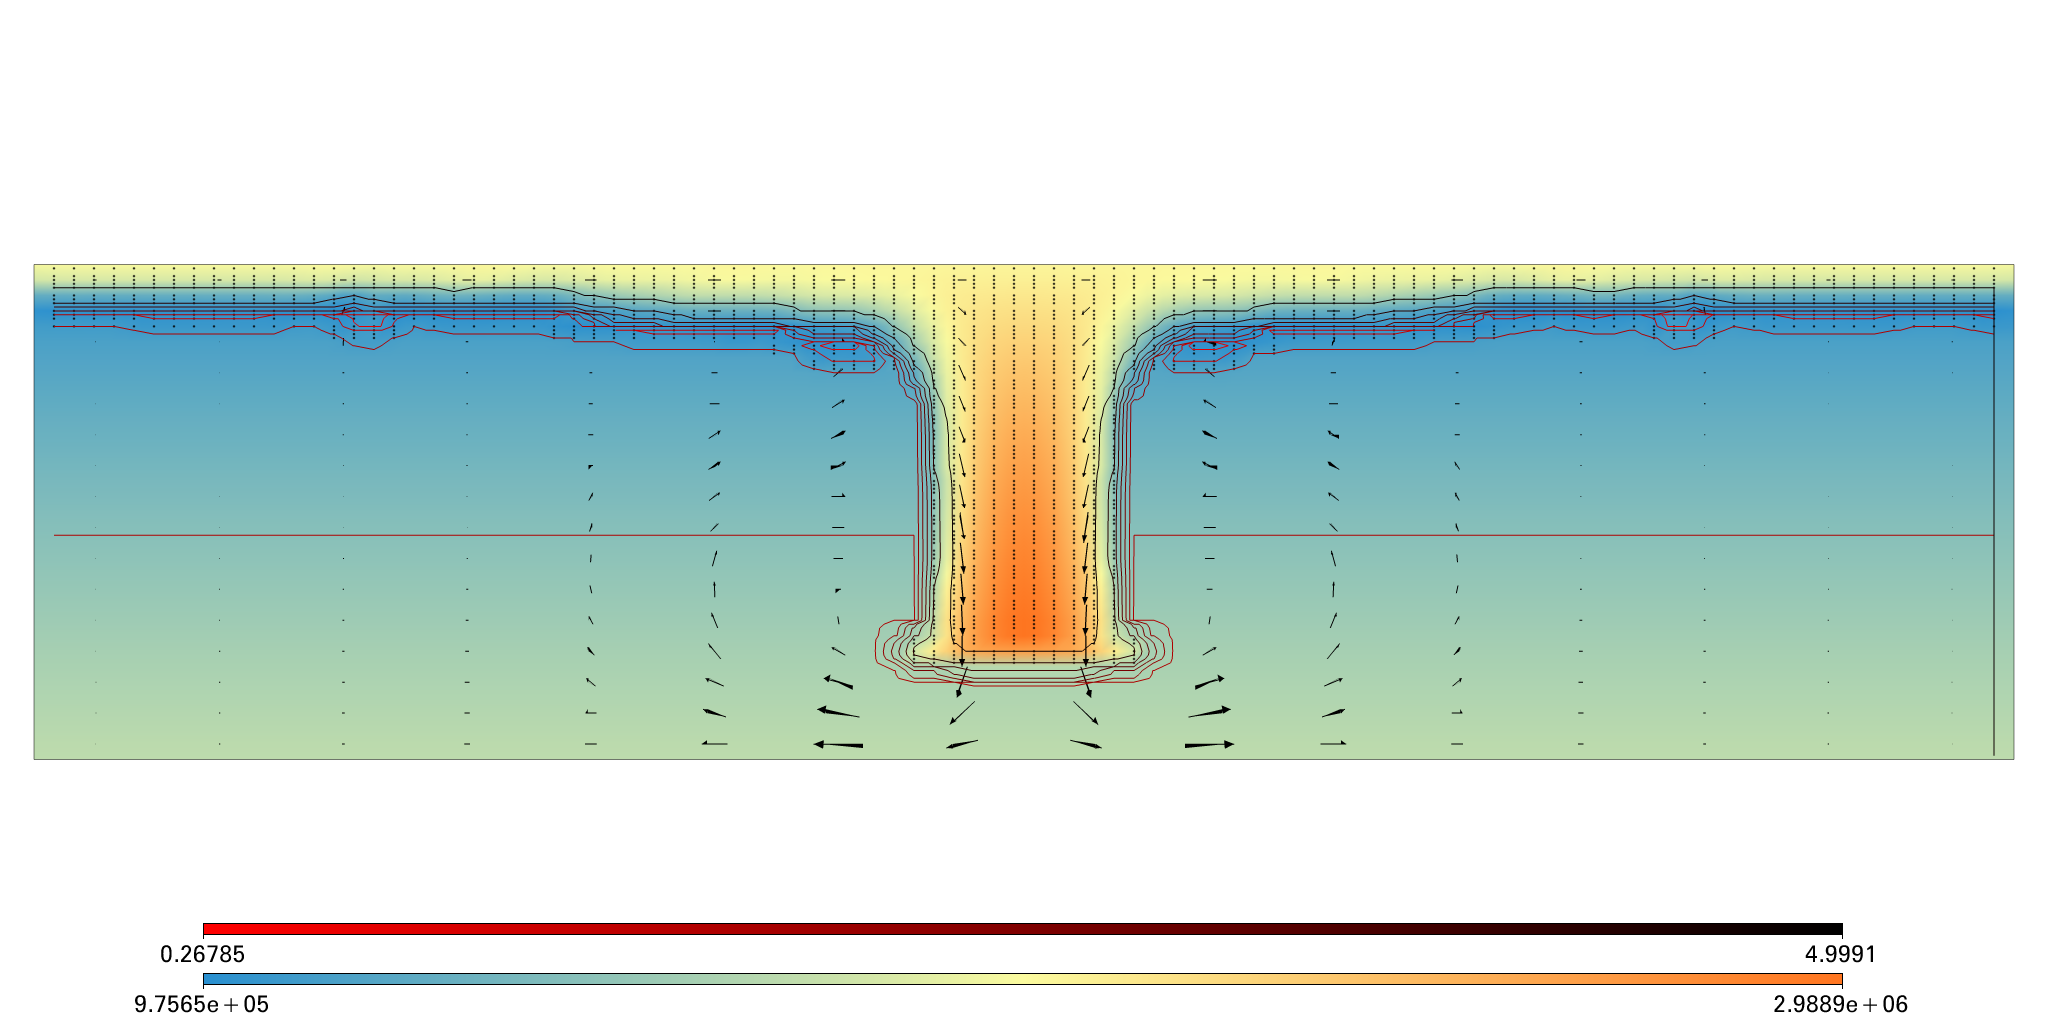

In [10]:
for i in range(100):
    system.iterate()
    print("Iteration " + str(i))
    if i % 10 == 0:
        show()
print("Done!")
show()

In [11]:
magVel = fn.math.sqrt(fn.math.dot(system.velocityField, system.velocityField))
lithoVelMag = fn.branching.map(
    fn_key = system.materialFn,
    mapping = {
        0: 0.,
        1: 0.,
        2: magVel,
        }
    )
lithoAngMag = fn.branching.map(
    fn_key = system.materialFn,
    mapping = {
        0: 0.,
        1: 0.,
        2: system.angMag,
        }
    )
lithoRadMag = fn.branching.map(
    fn_key = system.materialFn,
    mapping = {
        0: 0.,
        1: 0.,
        2: system.radMag,
        }
    )

Fitted 1 variables to the figure.



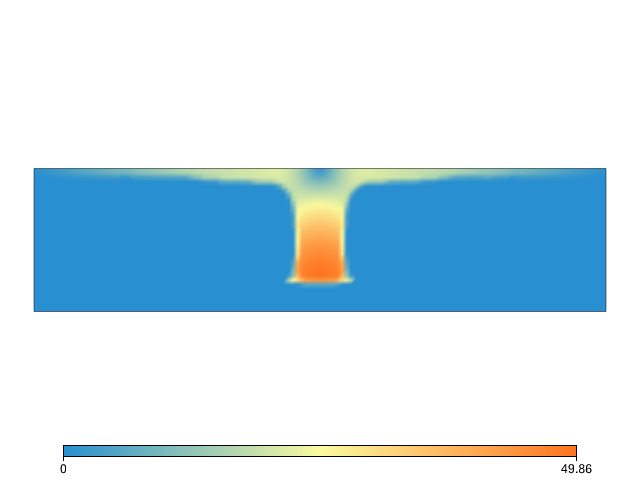

In [12]:
quickShow(lithoVelMag)

Fitted 1 variables to the figure.



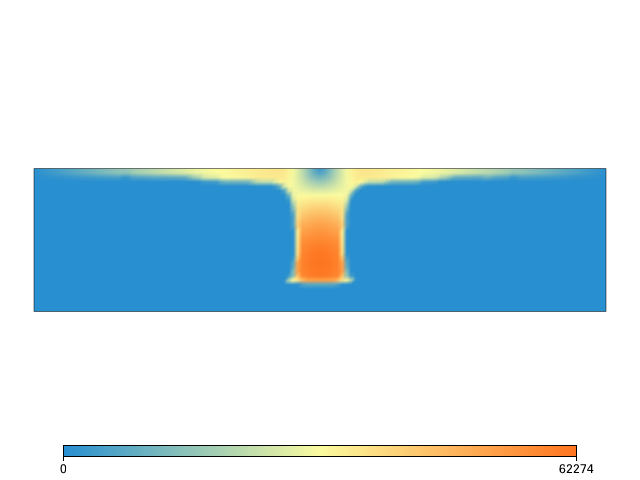

In [13]:
quickShow(system.viscosityFn * lithoVelMag)

Fitted 1 variables to the figure.



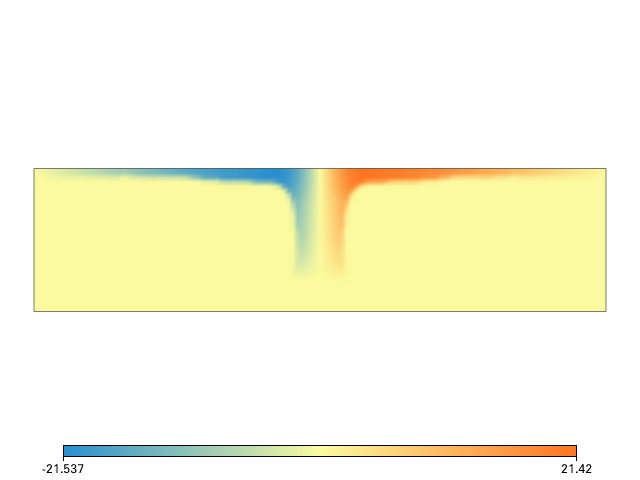

In [14]:
quickShow(lithoAngMag)

In [15]:
system.mesh.unitvec_theta_Fn.evaluate(system.outer)

array([[ -1.00000000e+00,   2.00001000e-05],
       [ -1.00000000e+00,   1.96875984e-05],
       [ -1.00000000e+00,   1.93750969e-05],
       [ -1.00000000e+00,   1.90625953e-05],
       [ -1.00000000e+00,   1.87500937e-05],
       [ -1.00000000e+00,   1.84375922e-05],
       [ -1.00000000e+00,   1.81250906e-05],
       [ -1.00000000e+00,   1.78125891e-05],
       [ -1.00000000e+00,   1.75000875e-05],
       [ -1.00000000e+00,   1.71875859e-05],
       [ -1.00000000e+00,   1.68750844e-05],
       [ -1.00000000e+00,   1.65625828e-05],
       [ -1.00000000e+00,   1.62500812e-05],
       [ -1.00000000e+00,   1.59375797e-05],
       [ -1.00000000e+00,   1.56250781e-05],
       [ -1.00000000e+00,   1.53125766e-05],
       [ -1.00000000e+00,   1.50000750e-05],
       [ -1.00000000e+00,   1.46875734e-05],
       [ -1.00000000e+00,   1.43750719e-05],
       [ -1.00000000e+00,   1.40625703e-05],
       [ -1.00000000e+00,   1.37500688e-05],
       [ -1.00000000e+00,   1.34375672e-05],
       [ -

Fitted 1 variables to the figure.



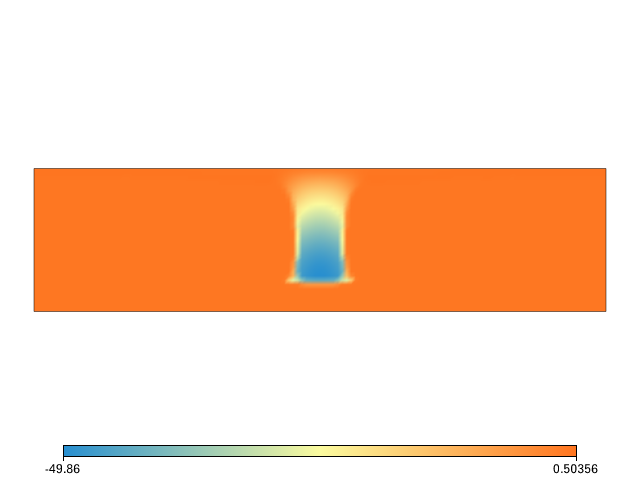

In [16]:
quickShow(lithoRadMag)

In [ ]:
# system = build(
#     res = 32,
#     Ra = 1e9,
#     strength = 1e6,
#     aspect = 8.,
#     slipperiness = 4.,
#     f = 1.,
#     astheno_thickness = 1. / 3.
#     )

In [ ]:
system = build(
    res = 32,
    Ra = 1e6,
    strength = 1e3,
    aspect = 4.,
    slipperiness = 4.,
    f = 1.,
    astheno_thickness = 1. / 3.
    )